In [24]:
# Den besten Zeitraum finden (Shift): Wir testen verschiedene Zeitabstände (z. B. 1 Minute, 5 Minuten oder 1 Stunde in die Zukunft), um herauszufinden, für welchen Zeitraum unsere Vorhersage am genauesten ist.
# Anpassung an die Daten: Wir suchen den „Sweet Spot“ in unseren Daten. Das Ziel ist es, das Modell auf den Zeitraum zu trainieren, in dem die Signale (wie Volumenänderungen) die stärkste Vorhersagekraft haben.
# AUC als Qualitätscheck: Der AUC-Wert (Area Under the Curve) zeigt uns, wie gut das Modell zwischen „echten Gewinnern“ und „echten Verlierern“ unterscheiden kann. Ein hoher Wert bedeutet: Weniger Fehlalarme.
# Alle Schwellenwerte testen: Wir prüfen nicht nur eine einzige Einstellung, sondern schauen uns an, wie stabil das Modell bei verschiedenen Risiko-Stufen (Cut-off-Thresholds) funktioniert.
# Beispiel Volumen: Wir untersuchen zum Beispiel bei Minutendaten: Sagt eine Volumenänderung den Preis in 1 Minute besser voraus oder vielleicht erst in 10 Minuten?
# Die Kernfrage: Wie weit müssen wir in die Zukunft schauen (der „Shift“), damit unser Modell die höchste Treffersicherheit erreicht und den maximalen Erfolg erzielt?

# Logistic Regression w/ all four Indicators

import numpy as np 
import pandas as pd
from pandas.plotting import lag_plot
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score # pip install scikit-learn
import yfinance_fix

[*********************100%***********************]  1 of 1 completed


 Exploring AUC over SHIFT range for SPY on 1d interval

Shift:  1 | AUC 0.5305
Shift:  2 | AUC 0.5126
Shift:  3 | AUC 0.5213
Shift:  4 | AUC 0.5185
Shift:  5 | AUC 0.5213
Shift:  6 | AUC 0.5207
Shift:  7 | AUC 0.5335
Shift:  8 | AUC 0.5344
Shift:  9 | AUC 0.5349
Shift: 10 | AUC 0.5367
Shift: 11 | AUC 0.5315
Shift: 12 | AUC 0.5330
Shift: 13 | AUC 0.5328
Shift: 14 | AUC 0.5259
Shift: 15 | AUC 0.5192
Shift: 16 | AUC 0.5205
Shift: 17 | AUC 0.5152
Shift: 18 | AUC 0.5179
Shift: 19 | AUC 0.5139
Shift: 20 | AUC 0.5177
Shift: 21 | AUC 0.5183
Shift: 22 | AUC 0.5183
Shift: 23 | AUC 0.5147
Shift: 24 | AUC 0.5150
Shift: 25 | AUC 0.5207
Shift: 26 | AUC 0.5229
Shift: 27 | AUC 0.5259
Shift: 28 | AUC 0.5275
Shift: 29 | AUC 0.5335
Shift: 30 | AUC 0.5363
Shift: 31 | AUC 0.5328
Shift: 32 | AUC 0.5315
Shift: 33 | AUC 0.5344
Shift: 34 | AUC 0.5273
Shift: 35 | AUC 0.5216
Shift: 36 | AUC 0.5237
Shift: 37 | AUC 0.5207
Shift: 38 | AUC 0.5201
Shift: 39 | AUC 0.5228
Shift: 40 | AUC 0.5277
Shift: 41 | AUC 0.5277
S

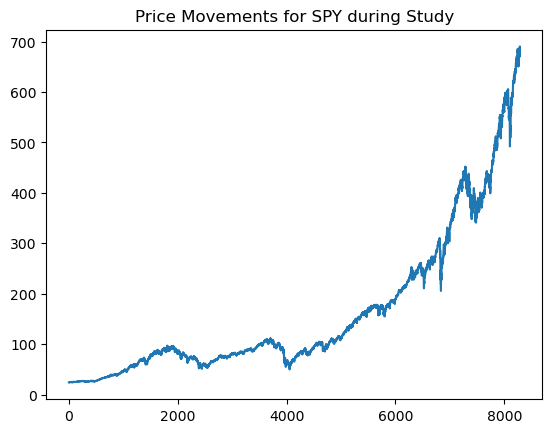

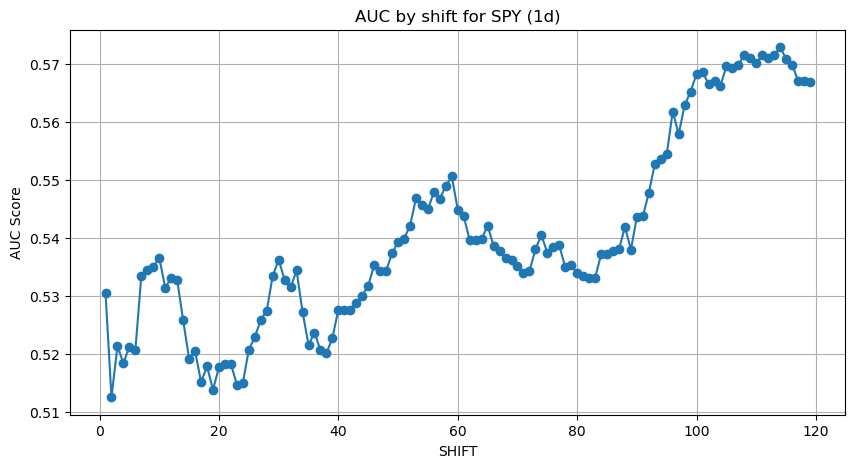


 Optimal SHIFT based on AUC: 114

 Running Final Model Analysis with SHIFT = 114


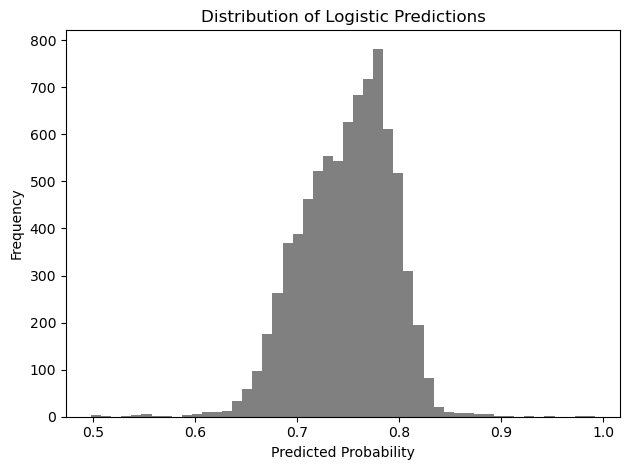

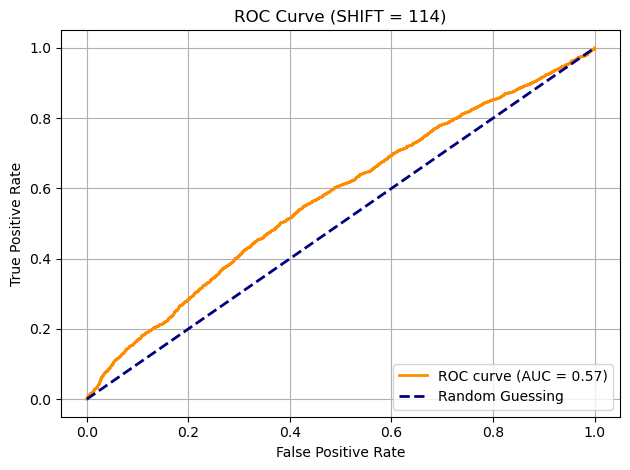

,Shift,AUC
0,114,0.572898
1,108,0.571609
2,111,0.571540
3,113,0.571487
4,112,0.571125
...,...,...
114,17,0.515228
115,24,0.515047
116,23,0.514749
117,19,0.513882


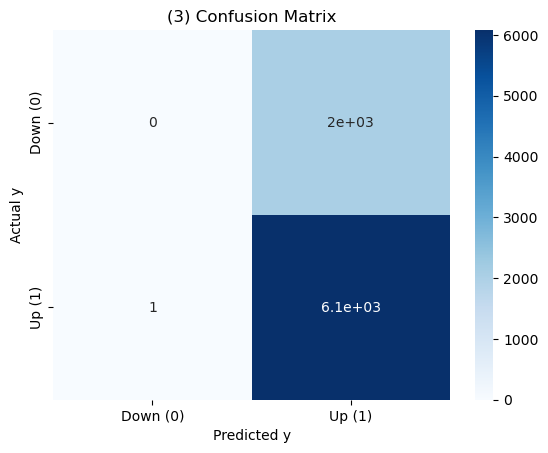

In [26]:
TICKER = "SPY"
INTERVAL = "1d"
PERIOD = "730d" if INTERVAL == "1h" else "max"

#   MACD
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9
#   MFI
MFI_LENGTH = 14 
OVERBROUGHT = 70
OVERSOLD = 30 
#   BB
BB_LENGTH = 20
STD_DEV = 2
#   RSI
RSI_LENGTH = 14
RSI_OVERBROUGHT = 70
RSI_OVERSOLD = 30

STRATEGY = ['Volume_Change', 'Close_Change' , 'High_Change', 'Low_Change', 'Open_Change', "MACD_HIST", "MFI", "BB", "RSI"]
SHIFT_RANGE = range(1, 120)
OPTIMAL_SHIFT = None
LOOKBACK = 10000

# --- (1) Daten herunterladen ---

def get_data(ticker=TICKER, interval=INTERVAL, lookback=LOOKBACK):
    df = yf.download(ticker, session=yfinance_fix.chrome_session, interval = interval, period = PERIOD)
    # WICHTIG: Prüfen, ob überhaupt Daten da sind!
    if df.empty:
        print(f"WARNUNG: Keine Daten für {ticker} erhalten!")
        return df # Gibt leeren DF zurück, damit main() das abfangen kann
    df.columns = df.columns.get_level_values(0)
    df = df.reset_index(drop=True)

    # Adding Price Changes 
    for c in df.columns:
        df[f"{c}_Change"] = df[f"{c}"].pct_change() * 100

    # Only return the subset of data you are interested in
    subset = df.iloc[-lookback:,:]
    plt.figure()
    plt.plot(subset["Close"])
    plt.title(f"Price Movements for {ticker} during Study")
    
    return df.iloc[-lookback:, :].dropna()

# --- (2) Unabhängige Variablen ("Features") definieren ---

def add_MACD(df, fast = MACD_FAST, slow = MACD_SLOW, span = MACD_SPAN):
    df[f"{fast}_ema"] = df["Close"].ewm(span = fast).mean()
    df[f"{slow}_ema"] = df["Close"].ewm(span = slow).mean()
    df["MACD"] = df[f"{fast}_ema"] - df[f"{slow}_ema"]
    df["Signal"] = df[f"MACD"].ewm(span = span).mean()
    df["MACD_HIST"] = df[f"MACD"] - df["Signal"]

    return df

def add_MFI(df, length = MFI_LENGTH):
    df["Average_Price"] = (df["High"]+df["Low"]+df["Close"])/3
    df["Money_Flow"] = df["Volume"]*df["Average_Price"]
    df["Pos_Flow"] = np.where(df["Average_Price"].diff()>0, df["Average_Price"], 0)
    df["Neg_Flow"] = np.where(df["Average_Price"].diff()<0, df["Average_Price"], 0)
    df["MFR"] = df["Pos_Flow"].rolling(window=length).sum() / df["Neg_Flow"].rolling(window=length).sum()
    df["MFI"] = (100 - 100 / (1 + df["MFR"]))

    return df.dropna()

def add_BB(df, std_dev = STD_DEV, length = BB_LENGTH):

    # Step 1: Middle Bend Column
    df["BB_SMA"] = df["Close"].rolling(window=length).mean()
    df["BB_STD"] = df["Close"].rolling(window=length).std()
    df["Upper Band"] = df["BB_SMA"] + (std_dev * df["BB_STD"])
    df["Lower Band"] = df["BB_SMA"] - (std_dev * df["BB_STD"])
    df["BB"] = ((df["Upper Band"] - df["Close"])/(df["Upper Band"] -   df["Lower Band"]))


    return df.dropna()

def add_RSI(df, length = RSI_LENGTH, overbrought = RSI_OVERBROUGHT, oversold = RSI_OVERSOLD):

    price_change = df["Close"].diff()
    df["gain"] = price_change.where(price_change > 0, 0)
    df["loss"] = - price_change.where(price_change < 0, 0)
 
    df["avg_gain"] = df["gain"].rolling(window = length).mean()
    df["avg_loss"] = df["loss"].rolling(window = length).mean()

    rs = df["avg_gain"] / df["avg_loss"]

    df["RSI"] = 100 - (100/(1+rs))


    return df.dropna()


# --- (3) Add Target ---
def add_target(df, shift):
    df = df.copy()
    df[f"Close + {shift}"] = df["Close"].shift(-shift)
    df["Target"] = (df[f"Close + {shift}"] > df["Close"]) * 1
    return df.dropna().reset_index(drop=True)

# --- (4) Generate Logistic Regression Output ---
def generate_regression_output(df, features=STRATEGY, target="Target"):
    subset = df[features + [target]].replace([np.inf, -np.inf], np.nan).dropna()

    if len(subset) < 10:
        raise ValueError("Too few rows after cleaning.")
    
    # To break temporal autocorrelation: shuffle all of teh columns alltogether
    # Which is only possible, because we are not creating a trading strategy. If we were, the data would have to alligned 
    # in a time series order, so latest to newest
    # 

    subset = subset.sample(frac=1, random_state=42).reset_index(drop=True)

    X = sm.add_constant(subset[features])
    y = subset[target]
    
    model = sm.Logit(y, X).fit(disp=0)
    y_pred_prob = model.predict(X)

    df = df.loc[subset.index]
    df["Prediction"] = (y_pred_prob > 0.5).astype(int)

    return df, y, y_pred_prob

# --- (5) Analyze Logistic Regression Output ---
def add_confusion_matrix(df):
    cm = confusion_matrix(df["Target"], df["Prediction"])
    labels = ["Down (0)", "Up (1)"]

    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    plt.figure()
    sns.heatmap(cm_df, annot = True, cmap = "Blues")
    plt.title("(3) Confusion Matrix")
    plt.xlabel("Predicted y")
    plt.ylabel("Actual y")

# ROC: Receiver Operating Characteristic Plot for Logistic Regression
def add_roc_plot(y_true, y_scores, title=f"ROC Curve"):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--", label="Random Guessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_prediction_distribution(y_pred_prob):
    plt.figure()
    plt.hist(y_pred_prob, bins=50, color="grey")
    plt.title("Distribution of Logistic Predictions")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# --- (6) Optimize for AUC (With Shift Range) ---

def explore_shift_auc(df_raw):
    print(f" Exploring AUC over SHIFT range for {TICKER} on {INTERVAL} interval\n")
    results = []

    for shift in SHIFT_RANGE:
        try:
            df = add_target(df_raw.copy(), shift)
            df, y, y_pred_prob = generate_regression_output(df)
            auc_score = roc_auc_score(y, y_pred_prob)
            print(f"Shift: {shift:2d} | AUC {auc_score:.4f}")
            results.append({"Shift": shift, "AUC": auc_score})
        except Exception as e:
            print(f"Shift {shift}: skipped due to error ({e})")

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="AUC", ascending=False).reset_index(drop=True)
    return results_df

def main():
    global OPTIMAL_SHIFT

    # Load and process data once:
    df_raw = get_data()
    df_raw = add_MACD(df_raw)
    df_raw = add_MFI(df_raw)
    df_raw = add_BB(df_raw)
    df_raw = add_RSI(df_raw)

    # Explore AUC over multiple shifts
    results_df = explore_shift_auc(df_raw)
    plot_df = results_df.sort_values(by="Shift")

    # Plot AUC vs. SHIFT 
    plt.figure(figsize=(10,5))
    plt.plot(plot_df["Shift"], plot_df["AUC"], marker="o")
    plt.title(f"AUC by shift for {TICKER} ({INTERVAL})")
    plt.xlabel("SHIFT")
    plt.ylabel("AUC Score")
    plt.grid(True)
    plt.show()

    # What this graphy could possibly guide us is:
    # I would place a trade on the minutely timeframe, I would want to hold my trade for {Optimal Shift} Min/Hour/Days
    # We want to find/see something closer to 0.60, becuase if our cutoff is 0.5, then we are just randomly seeing it 

    # Set optimal shift globally for future studies
    OPTIMAL_SHIFT = int(results_df.iloc[0]["Shift"])
    print(f"\n Optimal SHIFT based on AUC: {OPTIMAL_SHIFT}")

    # Final Study with Optimal shift
    print(f"\n Running Final Model Analysis with SHIFT = {OPTIMAL_SHIFT}")
    df_final = add_target(df_raw.copy(), shift=OPTIMAL_SHIFT)
    df_final, y_final, y_pred_prob = generate_regression_output(df_final)

    plot_prediction_distribution(y_pred_prob)
    add_roc_plot(y_final, y_pred_prob, title=f"ROC Curve (SHIFT = {OPTIMAL_SHIFT})")
    add_confusion_matrix(df_final)

    return results_df 

results_df = main()
results_df 

